# 双稳态基因调控网络模拟

本 notebook 实现了一个 **互相抑制的 toggle switch 模型**，展示：
- **(a)** 互相抑制模型的数学定义
- **(b)** A/B 随时间变化的轨迹
- **(c)** A-B 状态空间散点，用颜色表示时间


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 设置更好看的绘图风格
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


## 1) 模型定义：互相抑制的 toggle switch

数学模型：
$$\frac{dA}{dt} = \alpha_A \cdot \text{repress}(B) - \delta_A \cdot A$$
$$\frac{dB}{dt} = \alpha_B \cdot \text{repress}(A) - \delta_B \cdot B$$

其中 Hill 抑制函数为：
$$\text{repress}(x) = \frac{1}{1 + (x/K)^n}$$


In [2]:
def hill_repress(x, K=20.0, n=4.0):
    """Hill 抑制函数：x 越大，输出越接近 0"""
    return 1.0 / (1.0 + (x / K) ** n)


def simulate_toggle(
    T=5.0, dt=1e-3,
    alphaA=60.0, alphaB=60.0,
    deltaA=1.0, deltaB=1.0,
    K=20.0, n=4.0,
    A0=5.0, B0=40.0,
    noise=0.0,
    alphaA_schedule=None
):
    """
    模拟 toggle switch 动力学
    
    dA/dt = alphaA * repress(B) - deltaA * A
    dB/dt = alphaB * repress(A) - deltaB * B
    
    Parameters:
    -----------
    noise: 简单高斯噪声强度（教学用）
    alphaA_schedule: 如果传入函数 alphaA_schedule(t)，则 alphaA 随时间变化
    """
    steps = int(T / dt) + 1
    t = np.linspace(0, T, steps)
    A = np.zeros(steps)
    B = np.zeros(steps)
    A[0], B[0] = A0, B0
    
    for i in range(steps - 1):
        aA = alphaA_schedule(t[i]) if alphaA_schedule else alphaA
        aB = alphaB
        
        dA = aA * hill_repress(B[i], K, n) - deltaA * A[i]
        dB = aB * hill_repress(A[i], K, n) - deltaB * B[i]
        
        # 教学用噪声项（不是严格的化学主方程/Gillespie）
        if noise > 0:
            dA += noise * np.random.randn()
            dB += noise * np.random.randn()
        
        A[i + 1] = max(0.0, A[i] + dt * dA)
        B[i + 1] = max(0.0, B[i] + dt * dB)
    
    return t, A, B


In [6]:
print("=" * 50)
print("最终稳态结果：")
print("=" * 50)
print(f"初值 (40, 5)  → 终态: A = {A1[-1]:.2f}, B = {B1[-1]:.2f}")
print(f"初值 (5, 40)  → 终态: A = {A2[-1]:.2f}, B = {B2[-1]:.2f}")
print(f"初值 (10, 10.1) → 终态: A = {A3[-1]:.2f}, B = {B3[-1]:.2f}")
print(f"初值 (10.1, 10) → 终态: A = {A4[-1]:.2f}, B = {B4[-1]:.2f}")
print("\n→ 可以看到：微小的初值差异导致完全不同的命运！")


最终稳态结果：
初值 (40, 5)  → 终态: A = 59.86, B = 0.80
初值 (5, 40)  → 终态: A = 0.80, B = 59.86
初值 (10, 10.1) → 终态: A = 4.84, B = 52.64
初值 (10.1, 10) → 终态: A = 52.64, B = 4.84

→ 可以看到：微小的初值差异导致完全不同的命运！


## 3) 分岔过程演示

让 αA 随时间缓慢上升，模拟"参数漂移导致的命运转变"


## 4) 可选：加噪声，更像"随机分子轨迹"


---

## 总结

通过这个 notebook，我们展示了：

1. **双稳态现象**：相同参数、不同初值 → 收敛到不同稳态
2. **分岔过程**：参数随时间变化会导致系统"命运转变"
3. **噪声效应**：添加噪声让轨迹更接近真实的随机分子动力学

### 下一步

如果想要更严格的随机模拟，可以实现 **Gillespie SSA** 算法。


---

## 6) Gillespie SSA：精确随机模拟

前面的 ODE 模拟是**确定性**的，产生光滑曲线。而论文中 Figure 1.3(b) 使用的是 **Gillespie 算法**（Stochastic Simulation Algorithm），它：

- 把分子数建模为**离散整数**
- 每个反应（产生/降解）是独立的**随机事件**
- 反应之间的等待时间服从**指数分布**
- 精确采样自 **Chemical Master Equation (CME)**

这会产生内禀的随机涨落，更接近真实的分子动力学。
- Gillespie 不是ODE + noise，本质区别：Gillespie 模拟的是一个 跳跃过程（Jump Process），不是连续微分！
- CME 告诉你：在 t 时刻，这 1000 个宇宙中有多少比例处于状态 (a,b)
$$P(\text{A}=102, \text{B}=99 \text{ at } t=0.1) = ?$$
- CME 是一组巨大的 ODE，追踪每一个可能状态的概率。
- CME: CTMC 的 Kolmogorov 前向方程
- Gillespie : CTMC 的 精确模拟算法


### 好问题：

问题1："分子数越少，噪声越大"的理论和代码体现\
理论：泊松噪声，在 SSA 中，分子数服从泊松分布，\
相对噪声（CV） = 标准差/平均值 = √N / N = 1/√N 
$$\text{CV} = \frac{\sigma}{\mu} = \frac{\sqrt{N}}{N} = \frac{1}{\sqrt{N}}$$


 
 问题2：SSA 的 G vs ODE 的 G

 |            | SSA                                      | ODE                                 |
 |------------|------------------------------------------|-------------------------------------|
 | G 代表     | 分子数（molecule count）                 | 浓度（concentration）                      | 
 | 数据类型   | 离散整数（0, 1, 2, 3...）            | 连续实数（1.234...）                |
 | 变化方式   | 每次 ±1                                      | 连续变化 dG/dt                            |
 | 单位       | 个（molecules）                         | mol/L 或 nM 等                       |
 



问题3：对比代码（SSA + ODE）

| Row | 模型 | 稳态分子数 | 相对噪声 CV | 行为             |
|-----|------|------------|-------------|------------------|
| 1   | SSA  | ~5         | ~45%        | 频繁跳跃         |
| 2   | SSA  | ~50        | ~14%        | 偶尔跳跃/更稳定  |
| 3   | ODE  | ∞ (连续)   | 0%          | 完全稳定，无跳跃 |

这个对比清楚地展示了：分子数 → ∞ 时，SSA → ODE！




In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 设置更好看的绘图风格
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12



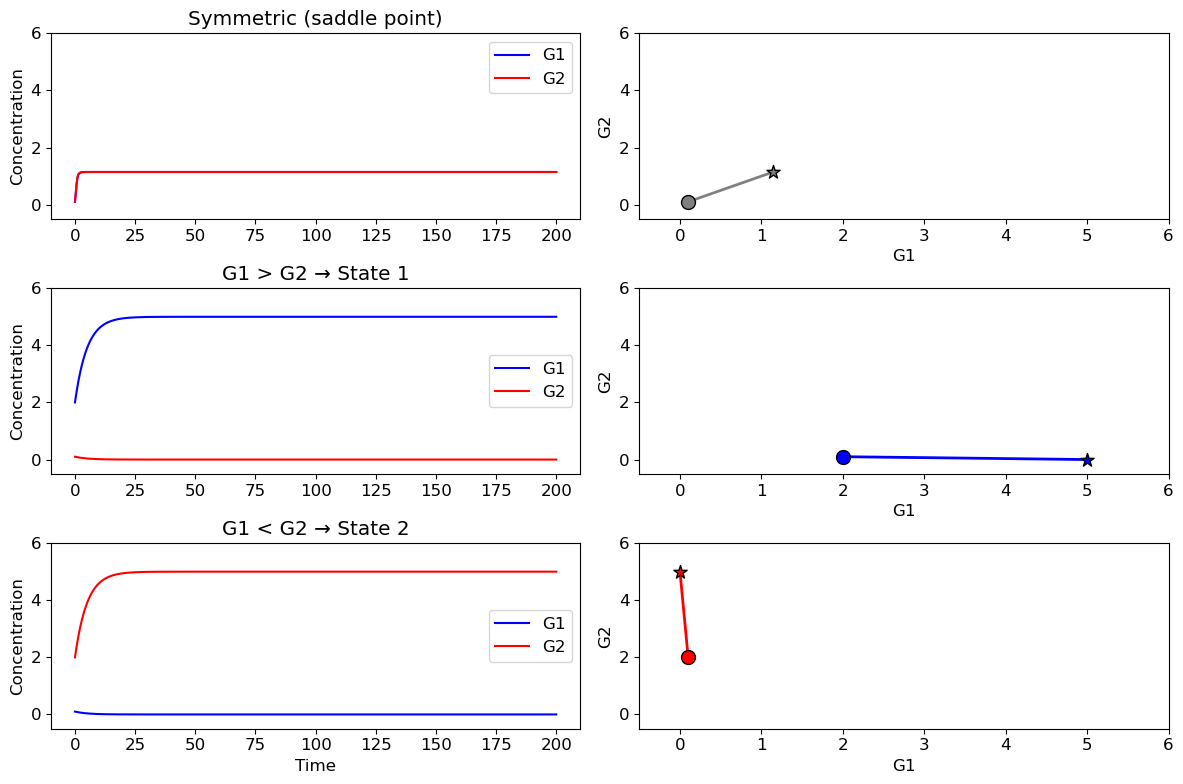

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

k_1 = 1
gamma_1 = 0.2
k_2 = 1
gamma_2 = 0.2
c = 1
h = 9

def toggle_switch_ode(y, t, k_1, k_2, gamma_1, gamma_2, c, h):
    G1, G2 = y
    dG1_dt = k_1 * (c**h / (c**h + G2**h)) - gamma_1 * G1
    dG2_dt = k_2 * (c**h / (c**h + G1**h)) - gamma_2 * G2
    return [dG1_dt, dG2_dt]

t = np.linspace(0, 200, 2000)

# 三种不同的初始条件
initial_conditions = [
    ([0.1, 0.1], 'Symmetric (saddle point)', 'gray'),
    ([2.0, 0.1], 'G1 > G2 → State 1', 'blue'),
    ([0.1, 2.0], 'G1 < G2 → State 2', 'red'),
]

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

for i, (y0, title, color) in enumerate(initial_conditions):
    solution = odeint(toggle_switch_ode, y0, t, args=(k_1, k_2, gamma_1, gamma_2, c, h))
    
    axes[i, 0].plot(t, solution[:, 0], color='blue', label='G1')
    axes[i, 0].plot(t, solution[:, 1], color='red', label='G2')
    axes[i, 0].set_ylabel('Concentration')
    axes[i, 0].set_title(f'{title}')
    axes[i, 0].legend()
    axes[i, 0].set_ylim(-0.5, 6)
    
    # 相图轨迹
    axes[i, 1].plot(solution[:, 0], solution[:, 1], color=color, linewidth=2)
    axes[i, 1].scatter(y0[0], y0[1], s=100, c=color, marker='o', edgecolors='black', zorder=5)
    axes[i, 1].scatter(solution[-1, 0], solution[-1, 1], s=100, c=color, marker='*', edgecolors='black', zorder=5)
    axes[i, 1].set_xlabel('G1')
    axes[i, 1].set_ylabel('G2')
    axes[i, 1].set_xlim(-0.5, 6)
    axes[i, 1].set_ylim(-0.5, 6)

axes[2, 0].set_xlabel('Time')
plt.tight_layout()
plt.show()

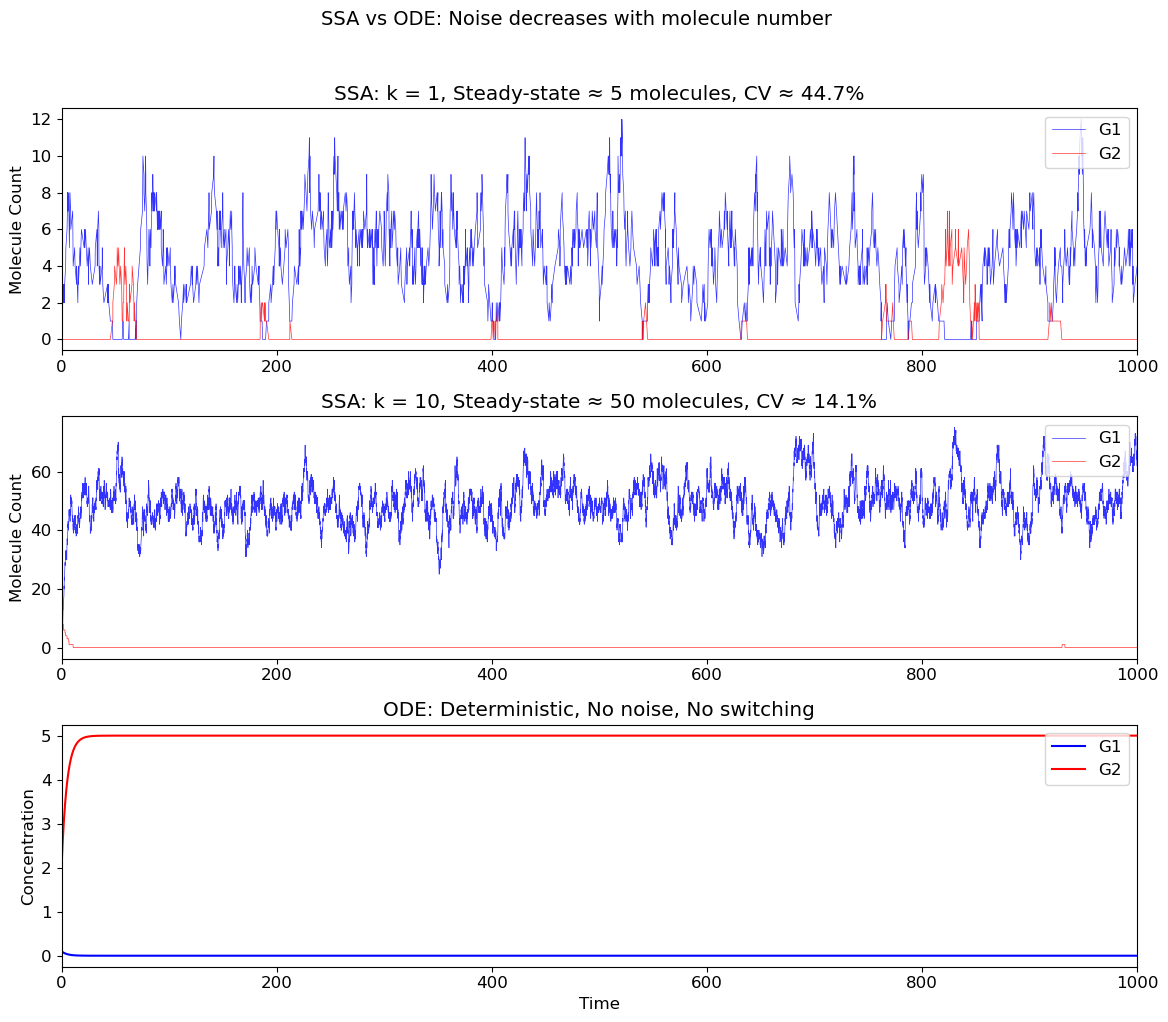

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint

# ODE 模型定义
def toggle_switch_ode(y, t, k_1, k_2, gamma_1, gamma_2, c, h):
    G1, G2 = y
    dG1_dt = k_1 * (c**h / (c**h + G2**h)) - gamma_1 * G1
    dG2_dt = k_2 * (c**h / (c**h + G1**h)) - gamma_2 * G2
    return [dG1_dt, dG2_dt]

# 比较不同的分子数量级
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# ============ Row 1 & 2: SSA with different molecule numbers ============
for idx, k_scale in enumerate([1, 10]):
    
    G1 = [0]
    G2 = [0]
    t = [0]
    
    tend = 1000
    k_1 = 1 * k_scale
    gamma_1 = 0.2
    k_2 = 1 * k_scale
    gamma_2 = 0.2
    c = 1 * k_scale
    h = 9
    
    while t[-1] < tend:
        props = [(c**h / (c**h + G2[-1]**h)) * k_1, gamma_1 * G1[-1],
                 (c**h / (c**h + G1[-1]**h)) * k_2, gamma_2 * G2[-1]]
        prop_sum = sum(props)
        if prop_sum == 0:
            prop_sum = 0.001
        tau = np.random.exponential(scale=1/prop_sum)
        t.append(t[-1] + tau)
        rand = random.uniform(0, 1)
        
        if rand * prop_sum <= props[0]:
            G1.append(G1[-1] + 1)
            G2.append(G2[-1])
        elif rand * prop_sum <= sum(props[:2]):
            G1.append(G1[-1] - 1)
            G2.append(G2[-1])
        elif rand * prop_sum <= sum(props[:3]):
            G1.append(G1[-1])
            G2.append(G2[-1] + 1)
        else:
            G1.append(G1[-1])
            G2.append(G2[-1] - 1)
    
    # G1 和 G2 画在同一个 panel
    axes[idx].plot(t, G1, 'b-', linewidth=0.5, label='G1', alpha=0.8)
    axes[idx].plot(t, G2, 'r-', linewidth=0.5, label='G2', alpha=0.8)
    axes[idx].set_ylabel('Molecule Count')
    axes[idx].set_title(f'SSA: k = {k_scale}, Steady-state ≈ {5*k_scale} molecules, CV ≈ {1/np.sqrt(5*k_scale)*100:.1f}%')
    axes[idx].legend(loc='upper right')
    axes[idx].set_xlim(0, tend)

# ============ Row 3: ODE ============
k_1 = 1
gamma_1 = 0.2
k_2 = 1
gamma_2 = 0.2
c = 1
h = 9

t_ode = np.linspace(0, 1000, 10000)
y0 = [0.1, 2.0]  # 非对称初始条件，避免卡在鞍点

solution = odeint(toggle_switch_ode, y0, t_ode, args=(k_1, k_2, gamma_1, gamma_2, c, h))

axes[2].plot(t_ode, solution[:, 0], 'b-', linewidth=1.5, label='G1')
axes[2].plot(t_ode, solution[:, 1], 'r-', linewidth=1.5, label='G2')
axes[2].set_ylabel('Concentration')
axes[2].set_xlabel('Time')
axes[2].set_title('ODE: Deterministic, No noise, No switching')
axes[2].legend(loc='upper right')
axes[2].set_xlim(0, 1000)

plt.suptitle('SSA vs ODE: Noise decreases with molecule number', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [10]:
def gillespie_toggle_switch(
    T_max=1.0,
    alpha_A=300.0, alpha_B=300.0,
    delta_A=1.0, delta_B=1.0,
    K=150.0, n=4.0,
    A0=100, B0=100
):
    """
    Gillespie SSA for mutual repression toggle switch.
    
    Reactions:
    1. ∅ → A  (production of A, repressed by B)
    2. A → ∅  (degradation of A)
    3. ∅ → B  (production of B, repressed by A)
    4. B → ∅  (degradation of B)
    
    Parameters:
    -----------
    T_max : float
        Maximum simulation time
    alpha_A, alpha_B : float
        Maximum production rates
    delta_A, delta_B : float
        Degradation rates
    K : float
        Hill function threshold
    n : float
        Hill coefficient
    A0, B0 : int
        Initial molecule counts
    """
    
    def hill_repress(x, K, n):
        return 1.0 / (1.0 + (x / K) ** n)
    
    # Initial state
    A, B = A0, B0
    t = 0.0
    
    # Record trajectory
    times = [t]
    A_traj = [A]
    B_traj = [B]
    
    while t < T_max:
        # Calculate propensities (reaction rates)
        a1 = alpha_A * hill_repress(B, K, n)  # A production
        a2 = delta_A * A                       # A degradation
        a3 = alpha_B * hill_repress(A, K, n)  # B production
        a4 = delta_B * B                       # B degradation
        
        a_total = a1 + a2 + a3 + a4
        
        if a_total == 0:
            break
        
        # 步骤1: 下一个事件什么时候发生？
        # Time to next reaction (exponential distribution) 
        tau = np.random.exponential(1.0 / a_total)
        t += tau
        
        if t > T_max:
            break
        
        
        # 步骤2: 发生哪个反应？
        # Which reaction fires? (proportional to propensity)
        r = np.random.random() * a_total
        
        if r < a1:
            A += 1              # A produced
        elif r < a1 + a2:
            A = max(0, A - 1)   # A degraded
        elif r < a1 + a2 + a3:
            B += 1              # B produced
        else:
            B = max(0, B - 1)   # B degraded
        
        # Record state
        times.append(t)
        A_traj.append(A)
        B_traj.append(B)
    
    return np.array(times), np.array(A_traj), np.array(B_traj)

print("Gillespie SSA 函数已定义 ✓")


Gillespie SSA 函数已定义 ✓


In [11]:
# 运行 Gillespie SSA 模拟 - 更接近 Figure 1.3(b) 的参数
# 
# 为了产生更大的涨落和可能的"切换"事件，我们需要：
# 1. 更高的分子数 (~200-300)
# 2. 更弱的双稳态（更容易发生切换）
# 3. 可能需要时间变化的参数来触发分岔

np.random.seed(42)  # 换一个种子，可能看到不同行为

# 参数调整：
# - 更高的 alpha 让稳态分子数更高
# - 较小的 n (Hill coefficient) 让双稳态更弱，更容易切换
# - K 相对于稳态较大，产生更大的涨落
t_ssa, A_ssa, B_ssa = gillespie_toggle_switch(
    T_max=1.0,
    alpha_A=350, alpha_B=350,  # 更高的产生率
    K=100, n=2.5,              # 更弱的 Hill 抑制（n 小 = 涨落大）
    A0=100, B0=250             # 初值偏向 B
)

print(f"模拟完成：共 {len(t_ssa)} 个反应事件")
print(f"最终状态：A = {A_ssa[-1]}, B = {B_ssa[-1]}")


模拟完成：共 615 个反应事件
最终状态：A = 54, B = 250


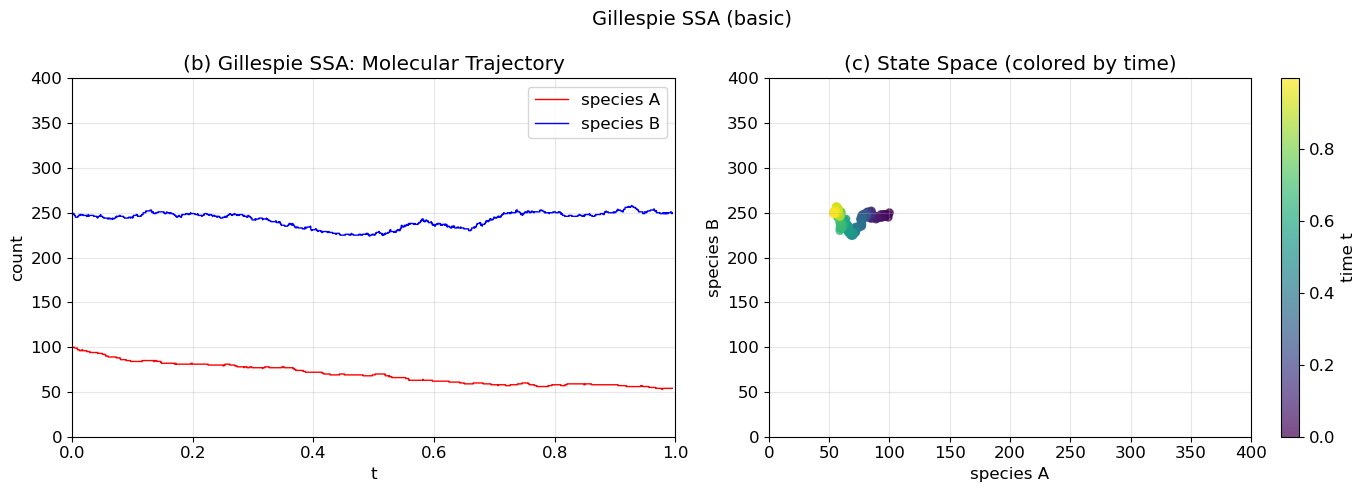

In [12]:
# 绘制 Gillespie SSA 结果 - 类似 Figure 1.3(b)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (b) 时间轨迹 - 使用阶梯图展示离散跳跃
ax1 = axes[0]
ax1.step(t_ssa, A_ssa, 'r-', where='post', linewidth=1, label='species A')
ax1.step(t_ssa, B_ssa, 'b-', where='post', linewidth=1, label='species B')
ax1.set_xlabel('t')
ax1.set_ylabel('count')
ax1.set_title('(b) Gillespie SSA: Molecular Trajectory')
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 400)
ax1.grid(alpha=0.3)

# (c) 状态空间散点，颜色表示时间
ax2 = axes[1]
# 均匀采样一些点用于散点图
sample_idx = np.linspace(0, len(t_ssa)-1, min(200, len(t_ssa))).astype(int)
sc = ax2.scatter(A_ssa[sample_idx], B_ssa[sample_idx], c=t_ssa[sample_idx], 
                  s=30, cmap='viridis', alpha=0.7)
ax2.set_xlabel('species A')
ax2.set_ylabel('species B')
ax2.set_title('(c) State Space (colored by time)')
plt.colorbar(sc, ax=ax2, label='time t')
ax2.set_xlim(0, 400)
ax2.set_ylim(0, 400)
ax2.grid(alpha=0.3)

plt.suptitle('Gillespie SSA (basic)', fontsize=14)
plt.tight_layout()
plt.show()


### 带分岔的 Gillespie SSA - 更接近 Figure 1.3(b)

Figure 1.3(b) 展示了一个**戏剧性的切换**：在 t≈0.8 时 B 突然下降。
这通常是由**时间变化的参数**（分岔）触发的。


/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/3926944419.py:42: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/3926944419.py:42: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/3926944419.py:42: UserWarning: Glyph 36857 (\N{CJK UNIFIED IDEOGRAPH-8FF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/3926944419.py:42: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90lq3412lbfx3drxzf3_9wh0000gn/T/ipykernel_13014/3926944419.py:42: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/23/j90l

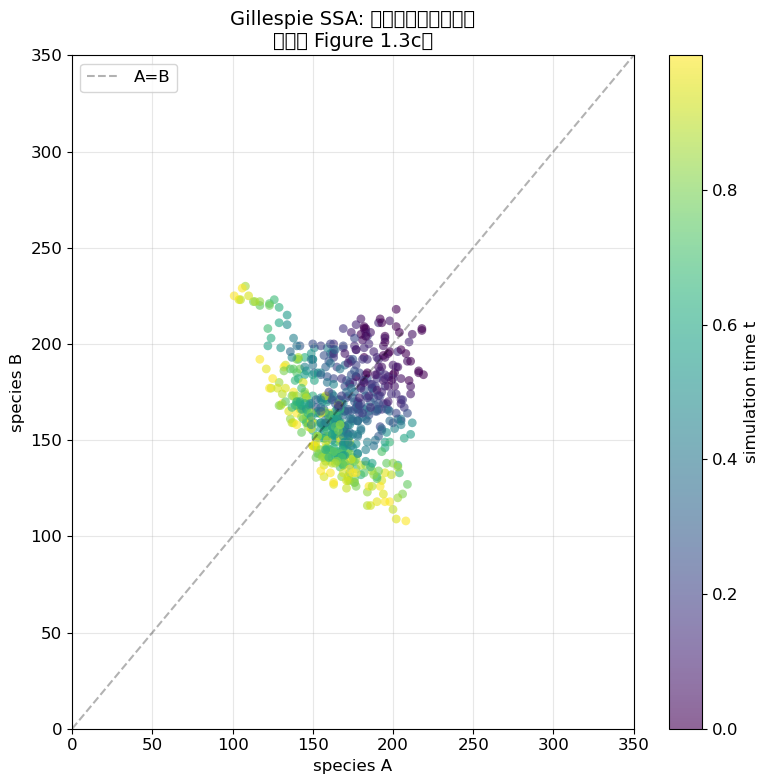

共采样 600 个状态点


In [ ]:
def gillespie_toggle_bifurcation(
    T_max=1.0,
    alpha_A_start=200.0, alpha_A_end=400.0,  # αA 随时间变化
    alpha_B=300.0,
    delta_A=1.0, delta_B=1.0,
    K=100.0, n=2.5,
    A0=100, B0=250
):
    """
    带分岔的 Gillespie SSA：αA 随时间增加，触发切换
    """
    def hill_repress(x, K, n):
        return 1.0 / (1.0 + (x / K) ** n)
    
    def get_alpha_A(t):
        # αA 线性增加
        return alpha_A_start + (alpha_A_end - alpha_A_start) * (t / T_max)
    
    A, B = A0, B0
    t = 0.0
    
    times = [t]
    A_traj = [A]
    B_traj = [B]
    
    while t < T_max:
        alpha_A = get_alpha_A(t)
        
        a1 = alpha_A * hill_repress(B, K, n)   # A production (increases over time!)
        a2 = delta_A * A
        a3 = alpha_B * hill_repress(A, K, n)
        a4 = delta_B * B
        
        a_total = a1 + a2 + a3 + a4
        if a_total == 0:
            break
        
        tau = np.random.exponential(1.0 / a_total)
        t += tau
        if t > T_max:
            break
        
        r = np.random.random() * a_total
        if r < a1:
            A += 1
        elif r < a1 + a2:
            A = max(0, A - 1)
        elif r < a1 + a2 + a3:
            B += 1
        else:
            B = max(0, B - 1)
        
        times.append(t)
        A_traj.append(A)
        B_traj.append(B)
    
    return np.array(times), np.array(A_traj), np.array(B_traj)


# 运行带分岔的模拟
np.random.seed(88)

t_bif, A_bif, B_bif = gillespie_toggle_bifurcation(
    T_max=1.0,
    alpha_A_start=150,  # 开始时 A 产生率低
    alpha_A_end=450,    # 结束时 A 产生率高
    alpha_B=300,
    K=100, n=2.5,
    A0=100, B0=250      # 初值偏向 B
)

print(f"模拟完成：共 {len(t_bif)} 个反应事件")
print(f"最终状态：A = {A_bif[-1]}, B = {B_bif[-1]}")


# 绘制带分岔的 Gillespie 结果 - 这个更接近 Figure 1.3(b)！
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (b) 时间轨迹
ax1 = axes[0]
ax1.step(t_bif, A_bif, 'r-', where='post', linewidth=1, label='species A')
ax1.step(t_bif, B_bif, 'b-', where='post', linewidth=1, label='species B')
ax1.set_xlabel('t')
ax1.set_ylabel('count')
ax1.set_title('(b) Gillespie SSA with Bifurcation')
ax1.legend()
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 400)
ax1.grid(alpha=0.3)

# (c) 状态空间
ax2 = axes[1]
sample_idx = np.linspace(0, len(t_bif)-1, min(300, len(t_bif))).astype(int)
sc = ax2.scatter(A_bif[sample_idx], B_bif[sample_idx], c=t_bif[sample_idx], 
                  s=30, cmap='viridis', alpha=0.7)
ax2.set_xlabel('species A')
ax2.set_ylabel('species B')
ax2.set_title('(c) State Space (colored by time)')
plt.colorbar(sc, ax=ax2, label='time t')
ax2.set_xlim(0, 400)
ax2.set_ylim(0, 400)
ax2.grid(alpha=0.3)

plt.suptitle('Gillespie SSA with Bifurcation (like Figure 1.3)', fontsize=14)
plt.tight_layout()
plt.show()


### 多轨迹采样：Figure 1.3(c) 风格


In [ ]:
# 多轨迹采样 - 展示 Figure 1.3(c) 的分岔效果
np.random.seed(42)

fig, ax = plt.subplots(figsize=(8, 8))

all_A, all_B, all_t = [], [], []

# 运行 50 条带分岔的轨迹
for i in range(50):
    A0 = np.random.randint(80, 120)
    B0 = np.random.randint(200, 280)
    
    t_traj, A_traj, B_traj = gillespie_toggle_bifurcation(
        T_max=1.0,
        alpha_A_start=150, alpha_A_end=450,
        alpha_B=300,
        K=100, n=2.5,
        A0=A0, B0=B0
    )
    
    # 每条轨迹采样约 10 个点
    n_samples = min(10, len(t_traj))
    idx = np.linspace(0, len(t_traj)-1, n_samples).astype(int)
    
    all_A.extend(A_traj[idx])
    all_B.extend(B_traj[idx])
    all_t.extend(t_traj[idx])

sc = ax.scatter(all_A, all_B, c=all_t, s=40, cmap='viridis', alpha=0.6, edgecolors='none')
ax.set_xlabel('species A', fontsize=12)
ax.set_ylabel('species B', fontsize=12)
ax.set_title('Multi-trajectory State Space (like Figure 1.3c)', fontsize=14)
plt.colorbar(sc, ax=ax, label='simulation time t')
ax.set_xlim(0, 400)
ax.set_ylim(0, 400)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Sampled {len(all_A)} state points from 50 trajectories")


---

## 总结：ODE vs Gillespie SSA

| 特性 | 确定性 ODE | Gillespie SSA |
|------|-----------|---------------|
| **状态变量** | 连续实数（浓度） | 离散整数（分子数） |
| **轨迹形态** | 光滑曲线 | 阶梯状涨落 |
| **随机性** | 无（除非手动加噪声） | 内禀随机性 |
| **理论基础** | 反应速率方程 | Chemical Master Equation |
| **适用场景** | 分子数很大时 | 分子数较少、随机效应重要时 |
| **计算效率** | 快（固定步长） | 较慢（事件驱动） |

**关键洞察**：
- 当分子数 N 很大时，Gillespie SSA 的相对涨落 ~ 1/√N 会变小，轨迹会趋近 ODE 解（这就是"热力学极限"）
- Figure 1.3(b) 的戏剧性切换来自于**时间变化的参数**穿过分岔点
- 涨落的大小取决于分子数和 Hill 系数 n（n 越大，双稳态越强，涨落相对越小）
